In [10]:
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt 
import os

In [51]:
OUT_DIR = 'out_bansal'

TEST = ["hello", "row-major", "column-major", "strassen"]
ARCH = ["arm64", "x64", "riscv64"]
SIZES = [8, 16, 32, 64]

EXTRACT_KEYS = {"simSeconds", "system.cpu.l1d.overallMisses::total", "system.cpu.ipc", "system.clk_domain.voltage_domain.voltage"}

data = defaultdict(dict) # data[test_name][stat_key] = value

for test in TEST:
    for arch in ARCH:
        for size in SIZES:
            test_name = f"{test}_{arch}_{size}_out"
            pathname = os.path.join(OUT_DIR, test_name, "stats.txt")
            with open(pathname) as f:
                for line in f:
                    split_line = [x for x in line.split(" ") if x]
                    if split_line[0] in EXTRACT_KEYS:
                        data[test_name][split_line[0]] = float(split_line[1])

            # Calculate Power Usage
            voltage = data[test_name]["system.clk_domain.voltage_domain.voltage"]
            ipc = data[test_name]["system.cpu.ipc"]
            dcache_misses = data[test_name]["system.cpu.l1d.overallMisses::total"]
            sim_seconds = data[test_name]["simSeconds"]

            # Assuming 2A per IPC, 3pA per cache miss
            data[test_name]["power"] = voltage * (2 * ipc + 3e-12 * dcache_misses / sim_seconds)


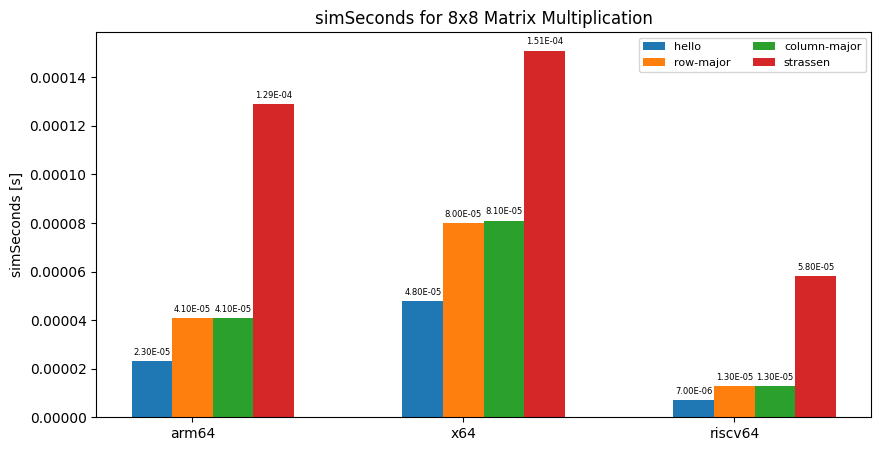

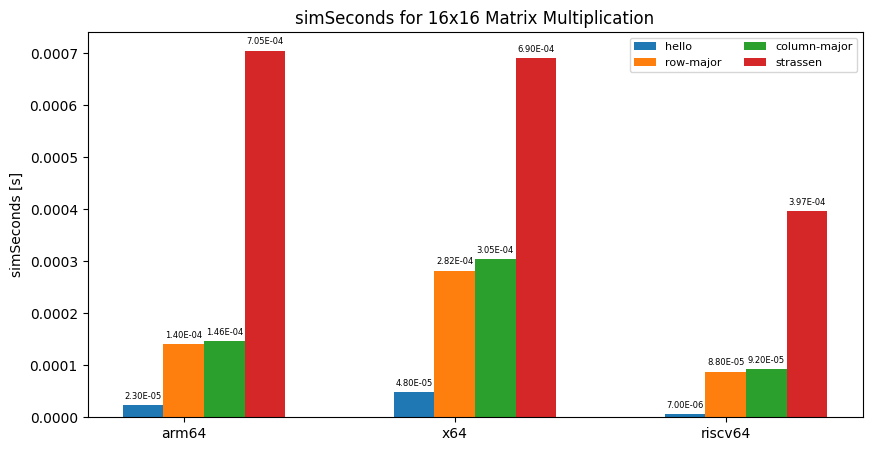

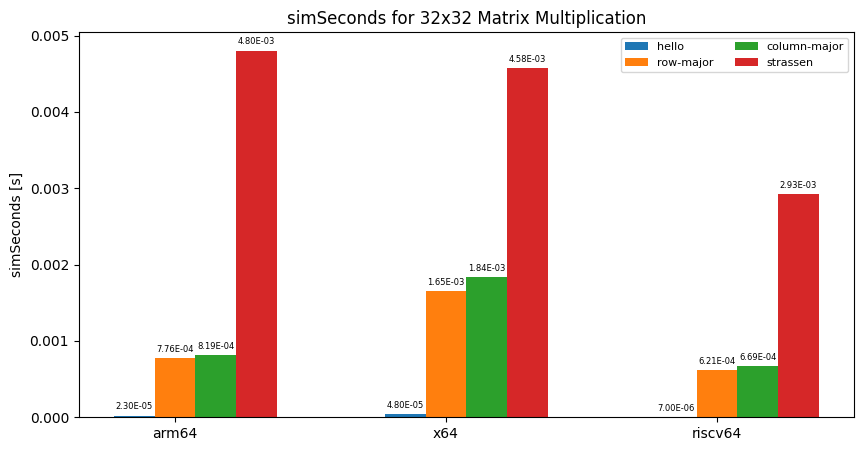

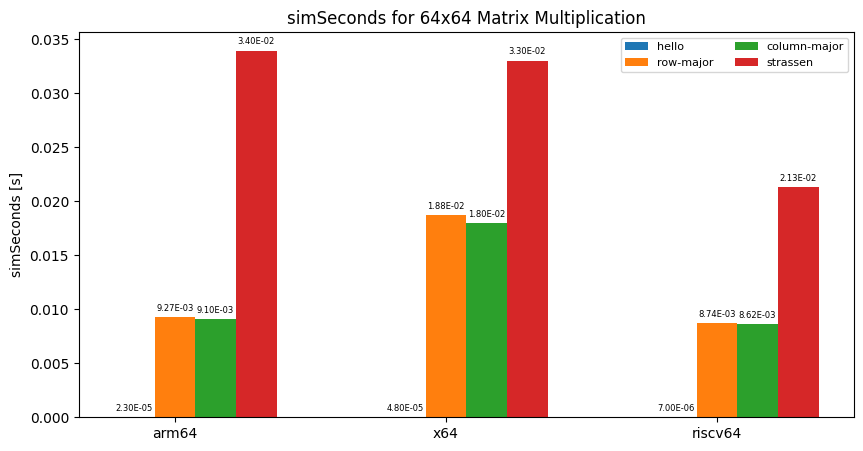

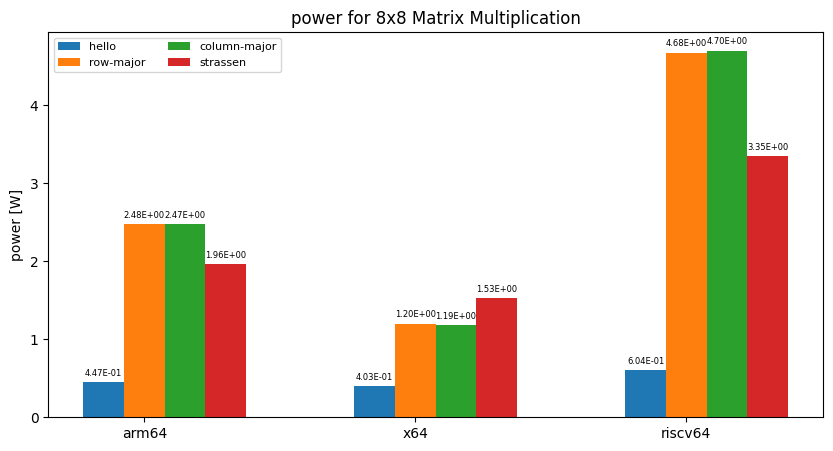

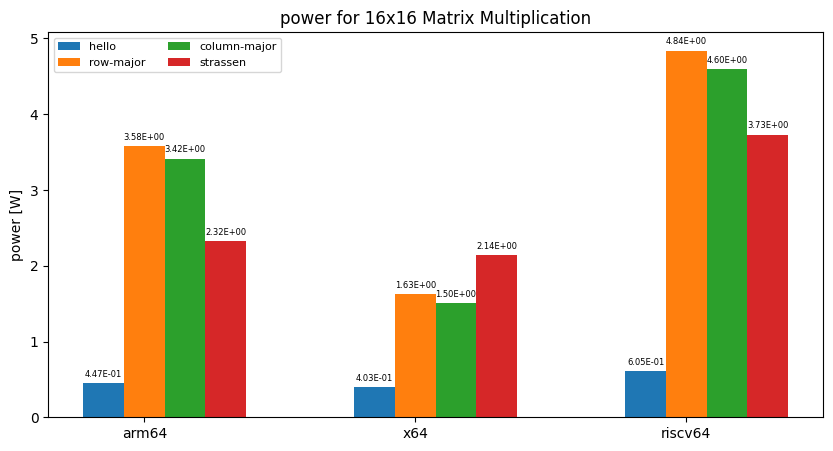

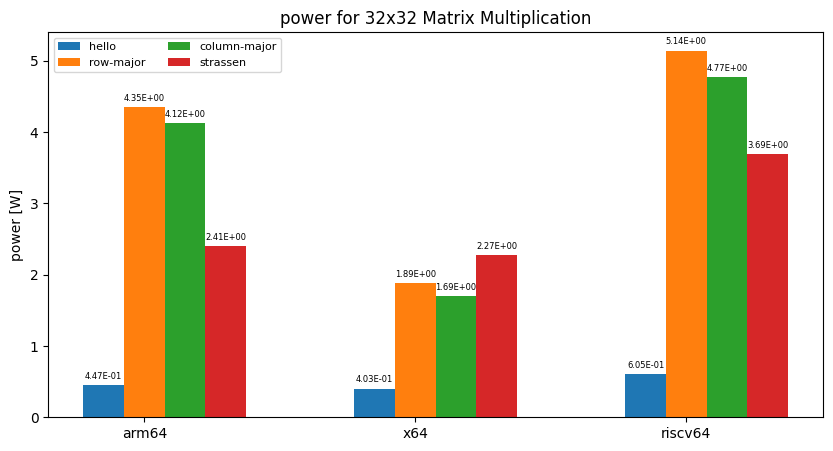

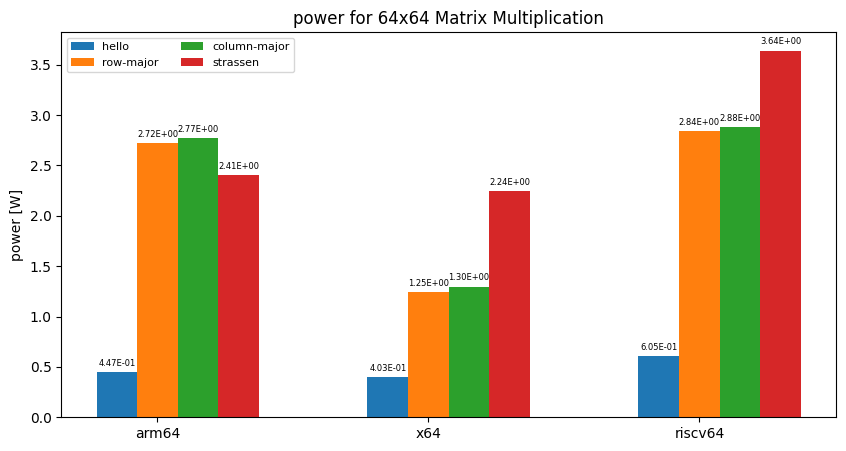

In [62]:
PLOT_STATS = [("simSeconds", "s"), ("power", "W")]

for stat, unit in PLOT_STATS:
    for size in SIZES:
        x = np.arange(len(ARCH))
        width = 0.15

        fig, ax = plt.subplots(figsize=(10, 5))

        for multiplier, test in enumerate(TEST):
            test_names = [f"{test}_{arch}_{size}_out" for arch in ARCH]
            test_data = [data[test_name][stat] for test_name in test_names]

            offset = width * multiplier
            rects = ax.bar(x + offset, test_data, width, label=test)
            ax.bar_label(rects, fontsize=6, fmt="%.2E", padding=3)

        ax.set_ylabel(f"{stat} [{unit}]")
        ax.set_title(f"{stat} for {size}x{size} Matrix Multiplication")
        ax.set_xticks(x + width, ARCH)
        ax.legend(loc="best", fontsize=8, ncols=len(TEST) // 2)

plt.show()

[1287807.1422436005, 636595.02700445, 2487469.57149039]
[1253691.4876287635, 603446.1108458594, 2427889.378503798]
[298260.7405493124, 285624.36375913746, 572625.8822549406]


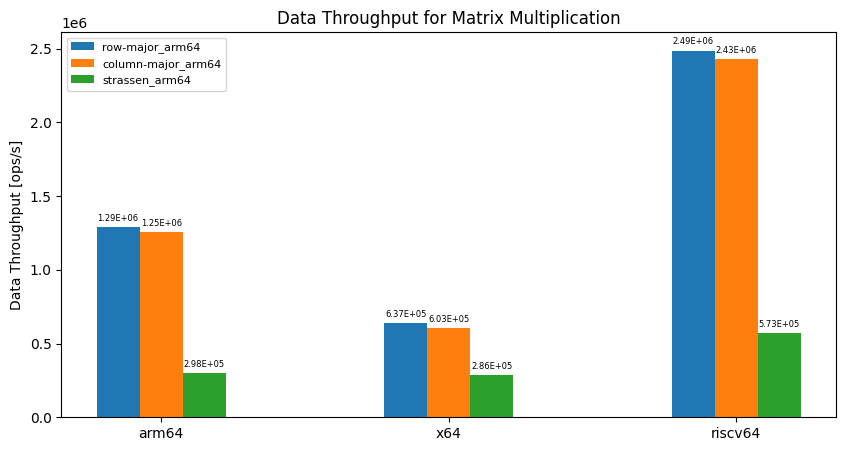

In [61]:
fig, ax = plt.subplots(figsize=(10, 5))

for multiplier, test in enumerate(TEST[1:]):
    test_data = [sum([(size * size)/data[f"{test}_{arch}_{size}_out"]["simSeconds"] for size in SIZES])/len(SIZES) for arch in ARCH]
    print(test_data)

    offset = width * multiplier
    rects = ax.bar(x + offset, test_data, width, label=f"{test}_{arch}")
    ax.bar_label(rects, fontsize=6, fmt="%.2E", padding=3)

ax.set_ylabel(f"Data Throughput [ops/s]")
ax.set_title(f"Data Throughput for Matrix Multiplication")
ax.set_xticks(x + width, ARCH)
ax.legend(loc="best", fontsize=8, ncols=len(TEST[1:]) // 2)

plt.show()